## Analysis of annotated Covid data

This notebook reads the extracted and merged **Covid data** (produced by `merging_cov.ipynb`). It runs timeseries analysis on annotated and non-annotated notes to provide descriptive analytics and plots.

In [2]:
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn
import statsmodels
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm

# Make graphics nice
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Set sensible defaults
sns.set()
sns.set_style("ticks")
sns.set_context('paper')

In [3]:
df = pd.read_csv('~/gianluca_data/data/covid_traindata_matched.tsv', sep='\t')
print(df.shape)

/data/homedirs/gianluca/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (0,2,3,5,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(2719728, 17)


In [ ]:
print([int(x) for x in df.patient_id.unique() if not np.isnan(x)])

In [7]:
types = [str(t) for t in list(df.type.unique())]
for t in sorted(types):
    print(t)

Addendum notitie
Anamnese & onderzoek
Anesthesie pre-op. evaluatie
Anesthesie verrichtingsnotities
Begeleidingsadviezen en afspraken
Beloop dwangtoepassingen
Brief
Co-assistent 1e jaars
Consulten
Consulten (niet-arts)
Crisisplan
Dagprogramma (tijdens opname)
Dieet voor patiënt
Downtime notities
Familiegesprek
Groepstherapie
Informatiekluis
Intake psychiatrie
Lactatie-notitie
MDO voorbereiding
MDO-verslag
Notitie voor beoordeling & plan
OBS Beleid
OK notitie
OK operatieverslag
Observatielijst
Ontslag - Instructies bij problemen/complicaties
Ontslag - Instructies wond/drains/lijnen etc
Ontslag - Medische instructies
Ontslaginstr. - activiteit
Ontslaginstr. - afspraken
Ontslaginstr. - apotheek
Ontslaginstr. - dieet
Ontslaginstr. - overige orders
Ontslagsamenvattingen
Operatie verslag
Patiëntinstructies
Postop. evaluatie anesthesie
Reanimatiedocumentatie
Research notitie
SEH arts notitie
SEH verslag
SEH-triagenotities
Signaleringsplan psychiatrie
Telefonisch contact
VK-bevallingsverslag
VP

In [4]:
df['date'] = pd.to_datetime(df['date'])
df = df[['date', 'patient_id', 'note_id', 'type', 'num_annot', 'annotator', 'annotations', 'sentence_id', 
         'sentence', 'note']]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2719728 entries, 0 to 2719727
Data columns (total 10 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   patient_id   float64       
 2   note_id      int64         
 3   type         object        
 4   num_annot    float64       
 5   annotator    object        
 6   annotations  object        
 7   sentence_id  float64       
 8   sentence     object        
 9   note         object        
dtypes: datetime64[ns](1), float64(3), int64(1), object(5)
memory usage: 207.5+ MB


In [6]:
df = df.sort_values('date', ascending=True)

In [48]:
df.groupby('date').count()

,patient_id,note_id,type,num_annot,annotator,annotations,sentence_id,sentence,note
date,,,,,,,,,
2020-01-01,0,3728,3495,0,0,0,0,0,3726
2020-01-02,0,10488,8937,0,0,0,0,0,10481
2020-01-03,0,10521,9127,0,0,0,0,0,10507
2020-01-04,0,4040,3713,0,0,0,0,0,4038
2020-01-05,0,4026,3760,0,0,0,0,0,4023
...,...,...,...,...,...,...,...,...,...
2020-09-21,0,13104,11389,0,0,0,0,0,13099
2020-09-22,0,13515,11842,0,0,0,0,0,13509
2020-09-23,0,11943,10385,0,0,0,0,0,11938


In [49]:
df.groupby('date').nunique()

,patient_id,note_id,type,num_annot,annotator,annotations,sentence_id,sentence,note
date,,,,,,,,,
2020-01-01,0,3480,34,0,0,0,0,0,3462
2020-01-02,0,9767,44,0,0,0,0,0,9397
2020-01-03,0,9788,46,0,0,0,0,0,9450
2020-01-04,0,3753,34,0,0,0,0,0,3698
2020-01-05,0,3792,37,0,0,0,0,0,3768
...,...,...,...,...,...,...,...,...,...
2020-09-21,0,12005,44,0,0,0,0,0,11721
2020-09-22,0,12434,44,0,0,0,0,0,12079
2020-09-23,0,10955,47,0,0,0,0,0,10633


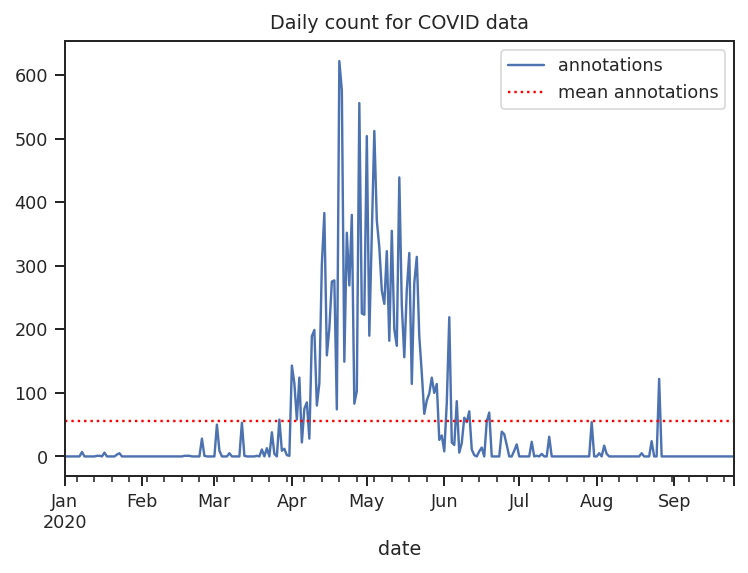

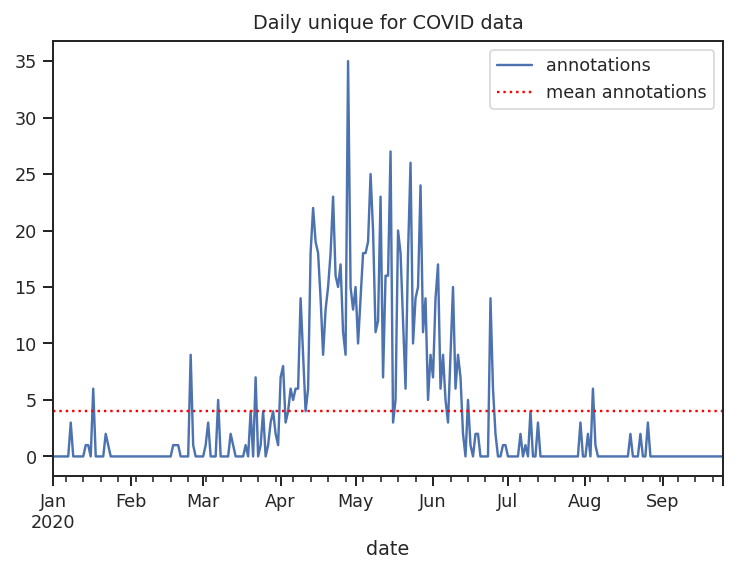

In [50]:
df.groupby('date').count()[['annotations']].plot()
plt.axhline(df.groupby('date').count()['annotations'].mean(), label='mean annotations', c='red', linestyle=':')
plt.legend()
plt.title("Daily count for COVID data")
plt.show()

df.groupby('date').nunique()[['annotations']].plot()
plt.axhline(df.groupby('date').nunique()['annotations'].mean(), label='mean annotations', c='red', linestyle=':')
plt.legend()
plt.title("Daily unique for COVID data")
plt.show()

In [51]:
df.groupby('date').sum()

,patient_id,note_id,num_annot,sentence_id
date,,,,
2020-01-01,0.0,1413760244045,0.0,0.0
2020-01-02,0.0,3975857608923,0.0,0.0
2020-01-03,0.0,3992184435910,0.0,0.0
2020-01-04,0.0,1536549741158,0.0,0.0
2020-01-05,0.0,1531874165747,0.0,0.0
...,...,...,...,...
2020-09-21,0.0,5855653816256,0.0,0.0
2020-09-22,0.0,6050545042015,0.0,0.0
2020-09-23,0.0,5357151564822,0.0,0.0


<AxesSubplot:xlabel='date'>

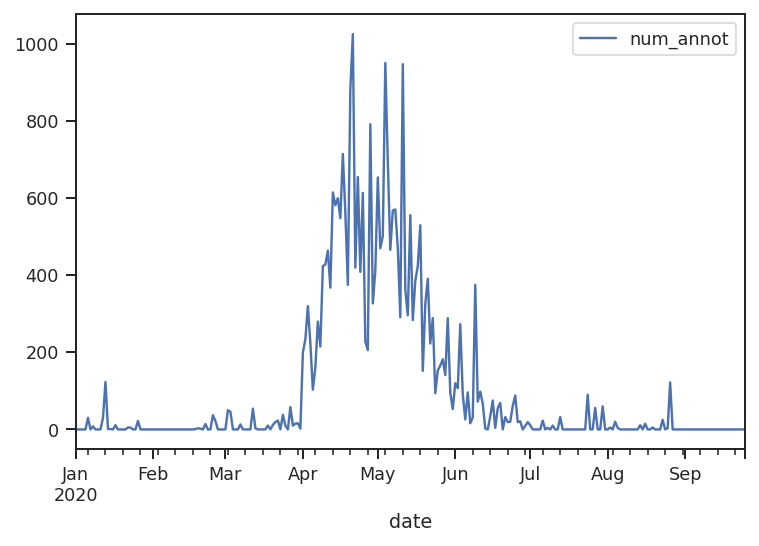

In [52]:
df.groupby('date').sum()[['num_annot']].plot()

In [53]:
df.columns

Index(['date', 'patient_id', 'note_id', 'type', 'num_annot', 'annotator',
       'annotations', 'sentence_id', 'sentence', 'note'],
      dtype='object')

In [54]:
df.patient_id.nunique(), df.note_id.nunique()

(60, 2410923)

In [55]:
df.groupby(['patient_id'])['note_id'].nunique().describe()

count     60.00000
mean      21.00000
std       21.93519
min        2.00000
25%        7.00000
50%       12.00000
75%       27.50000
max      104.00000
Name: note_id, dtype: float64

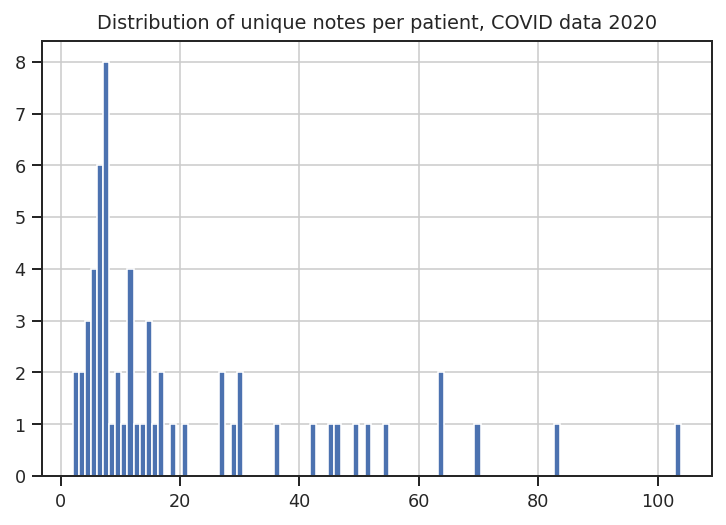

In [56]:
df.groupby(['patient_id'])['note_id'].nunique().head(200).hist(bins=100)
plt.title("Distribution of unique notes per patient, COVID data 2020")
plt.show()

In [15]:
df.groupby(['patient_id'])['note_id'].nunique().describe()

count     60.00000
mean      21.00000
std       21.93519
min        2.00000
25%        7.00000
50%       12.00000
75%       27.50000
max      104.00000
Name: note_id, dtype: float64

In [18]:
df.groupby(['patient_id'])['note_id'].nunique().median()

12.0

In [57]:
df.groupby(['date'])['note_id'].nunique().describe()

count      269.000000
mean      9037.457249
std       3810.909161
min          9.000000
25%       3885.000000
50%      11029.000000
75%      12005.000000
max      14176.000000
Name: note_id, dtype: float64

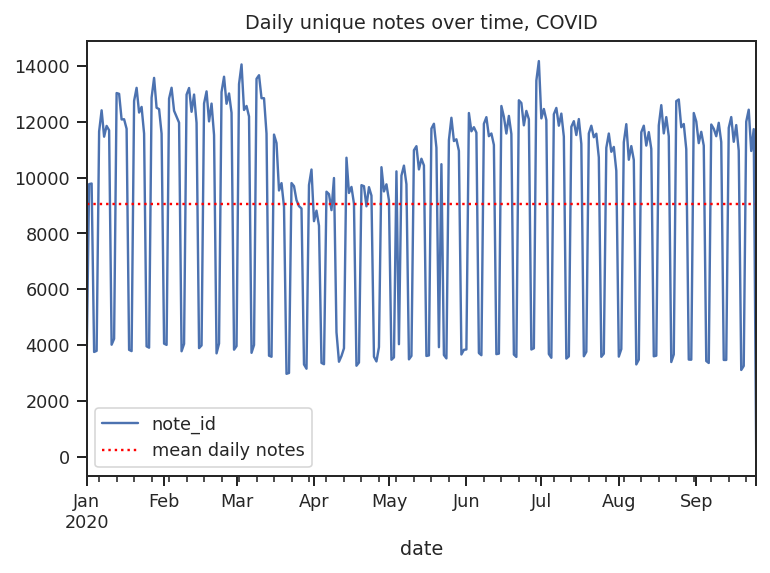

In [58]:
df.groupby(['date'])['note_id'].nunique().plot()
plt.axhline(df.groupby(['date'])['note_id'].nunique().mean(), label='mean daily notes', c='red', linestyle=':')
plt.title("Daily unique notes over time, COVID")
plt.legend()
plt.show()

In [59]:
#find what percentage of notes (not sentences) are annotated
_df = df.groupby('note_id').any()
n_annotated = _df[_df.annotations == True].shape[0]
print(n_annotated, _df.shape[0], n_annotated / _df.shape[0])

836 2410923 0.0003467551638936623


In [60]:
# TODO find percentage of notes that include annotations for 4 domains
DOMAINS = ['STM', 'INS', 'BER', 'FAC']

def count_domain(s, d):
    assert d in DOMAINS
    if not isinstance(s, str):
        return 0
    if d in s:
        return 1
    return 0
    
_df = df.copy()
for d in DOMAINS:
    _df[f"count_{d}"] = _df['annotations'].apply(count_domain, d=d)

In [61]:
# Look at domain counts across ALL notes
_df.groupby('note_id').sum()[['count_STM', 'count_INS', 'count_BER', 'count_FAC']].describe()

,count_STM,count_INS,count_BER,count_FAC
count,2.410923e+06,2.410923e+06,2.410923e+06,2.410923e+06
mean,1.522239e-04,8.627401e-05,4.147789e-07,1.065982e-04
std,1.913705e-02,1.462937e-02,6.440333e-04,1.680634e-02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.300000e+01,6.000000e+00,1.000000e+00,7.000000e+00


In [62]:
# Look at domain counts across only annotated notes
_df[~_df.annotations.isna()].groupby('note_id').sum()[
    ['count_STM', 'count_INS', 'count_BER', 'count_FAC']].describe()

,count_STM,count_INS,count_BER,count_FAC
count,836.000000,836.000000,836.000000,836.000000
mean,0.438995,0.248804,0.001196,0.307416
std,0.929805,0.745645,0.034586,0.849088
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,0.000000,0.000000
max,13.000000,6.000000,1.000000,7.000000


<AxesSubplot:>

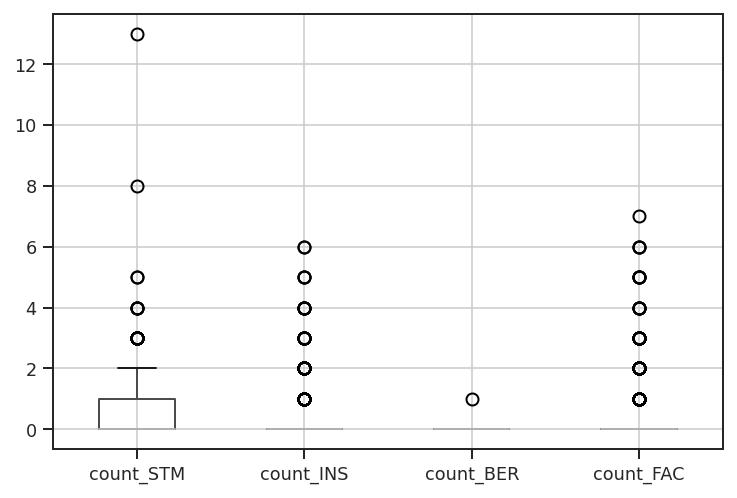

In [63]:
_df[~_df.annotations.isna()].groupby('note_id').sum().boxplot(column=['count_STM', 'count_INS', 'count_BER', 'count_FAC'])

In [64]:
# What fraction of notes are annotated with AT LEAST one of the domains
_df_grouped = _df[~_df.annotations.isna()].groupby(['note_id', 'patient_id']).sum()
_df_grouped['domain_count'] = _df_grouped.count_STM + _df_grouped.count_INS + _df_grouped.count_BER + _df_grouped.count_FAC
n_annot = _df_grouped.shape[0]
df_has_dom = _df_grouped[_df_grouped.domain_count > 0].shape[0]
print(df_has_dom, n_annot, df_has_dom / n_annot)

402 836 0.48086124401913877


In [65]:
# How many patients have at least one dom annotation
_df_grouped_patient = _df_grouped[_df_grouped.domain_count > 0].groupby('patient_id').mean()
print(_df_grouped_patient.shape)
_df_grouped_patient.describe()

(58, 7)


,num_annot,sentence_id,count_STM,count_INS,count_BER,count_FAC,domain_count
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,14.513508,594.731407,0.736048,0.486540,0.001916,0.718173,1.942677
std,9.031125,737.762372,0.565550,0.580568,0.014590,0.737535,0.796407
min,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,8.500000,147.464286,0.333333,0.000000,0.000000,0.017857,1.297619
50%,12.560440,305.500000,0.666667,0.408333,0.000000,0.569444,2.000000
75%,20.650000,844.161111,1.000000,0.666667,0.000000,1.000000,2.487903
max,48.000000,3472.000000,2.000000,3.000000,0.111111,2.750000,4.250000


In [66]:
# How many of these patients are useful for timeseries
_df['has_dom_annot'] = False
for pid in tqdm(_df_grouped_patient.reset_index().patient_id):
    _df.loc[_df.patient_id == pid, 'has_dom_annot'] = True
    
_df[_df.has_dom_annot].patient_id.nunique()

100%|██████████| 58/58 [00:00<00:00, 220.79it/s]


58

In [67]:
# How many patients have more than 2 domain annotations over time

def count_positive_doms(xs):
    pos = xs[xs > 0]
    return len(pos)

count_cols = ['count_STM', 'count_INS', 'count_BER', 'count_FAC']

_df_notes = _df[~_df.annotations.isna()].groupby(['note_id', 'patient_id']).sum()
_df_patients = _df_notes.groupby(['patient_id']).agg(count_positive_doms)
# _df_patients
useful_patients = _df_patients[(_df_patients[count_cols] > 1).any(axis=1)].index
print(len(useful_patients), useful_patients[:10])

46 Float64Index([ 762325.0, 1049919.0, 1185845.0, 1188552.0, 1550849.0, 1610429.0,
              1695264.0, 1812801.0, 1827821.0, 1828641.0],
             dtype='float64', name='patient_id')


In [68]:
_df_ts = _df[_df.patient_id.isin(useful_patients)].groupby(['patient_id', 'note_id', 'date']).sum().reset_index()
_df_ts = _df_ts[_df_ts[count_cols].any(axis=1)]
_df_ts

,patient_id,note_id,date,num_annot,sentence_id,count_STM,count_INS,count_BER,count_FAC,has_dom_annot
0,762325.0,413647830,2020-05-04,5.0,45.0,0,4,0,0,10
4,762325.0,414683173,2020-05-08,2.0,231.0,0,1,0,0,22
6,762325.0,415866477,2020-05-13,3.0,136.0,1,0,0,0,17
8,762325.0,416146847,2020-05-14,31.0,48516.0,0,1,0,0,312
10,762325.0,416787789,2020-05-17,4.0,253.0,1,1,0,0,23
...,...,...,...,...,...,...,...,...,...,...
1155,8381579.0,418974382,2020-05-26,3.0,741.0,1,0,0,0,39
1157,8381579.0,419024490,2020-05-26,39.0,4186.0,0,0,0,2,92
1163,9816148.0,394526217,2020-02-20,2.0,190.0,0,0,0,1,20
1165,9816148.0,396102164,2020-02-26,2.0,13041.0,0,1,0,0,162


In [69]:
# Of these useful patients (with multiple annotated domains), how many different observations do we have?
_df_ts.groupby('patient_id').count()[count_cols].describe()

,count_STM,count_INS,count_BER,count_FAC
count,46.000000,46.000000,46.000000,46.000000
mean,8.434783,8.434783,8.434783,8.434783
std,8.090192,8.090192,8.090192,8.090192
min,2.000000,2.000000,2.000000,2.000000
25%,4.000000,4.000000,4.000000,4.000000
50%,5.500000,5.500000,5.500000,5.500000
75%,9.750000,9.750000,9.750000,9.750000
max,43.000000,43.000000,43.000000,43.000000


In [ ]:
# Look at intervals between useful (domain annotated) observations

def spread(arr):
    diffs = []
    for t1, t2 in zip(arr, arr[1:]):
        diffs.append(pd.Timedelta(t2 - t1))
#     print(arr, diffs)
    return np.mean(diffs)

In [14]:
df.groupby('patient_id')['date'].agg(spread).describe()

count                           60
mean     0 days 01:41:37.892934841
std      0 days 03:15:14.500597375
min      0 days 00:07:34.736842105
25%      0 days 00:28:28.799058084
50%      0 days 00:43:24.334847501
75%      0 days 01:22:45.115939162
max      0 days 22:49:45.365853658
Name: date, dtype: object

In [71]:
df.annotations.value_counts(dropna=False).head(50)

NaN                                                          2704665
type\_Background                                               10965
target                                                          2810
info\_Third party                                                215
.D450: Lopen en zich verplaatsen                                  68
STM 1 | .B152: Stemming                                           65
.B455: Inspanningstolerantie | INS 1                              40
STM 0 | .B152: Stemming                                           32
.B455: Inspanningstolerantie | INS 0                              29
.B152: Stemming | STM 2                                           28
.B455: Inspanningstolerantie                                      27
lop\_hulpmiddel                                                   27
type\_Background | type\_Background                               26
*                                                                 24
type\_Implicit | .D450: Lopen en z

In [ ]:
DOMAINS = [
    'STM',  # B152 stemming (mood) 0-4
    'INS',  # B455 Inspanningstolerantie (exercise tolerance) 0-5
    'BER',  # D840-859 Beroep en werk (profession and work) 0-4
    'FAC',  # D450 Lopen en zich verplaatsen (walking and movement) 0-5
]

In [16]:
df['patient_id'].nunique()

60

In [19]:
df['note_id'].nunique()

2410923